In [1]:
import pyedflib
import numpy as np

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [2]:
sr = 256
batch_size = 64
preictal_time = 20 * 60 * sr
siez_starts = [2996, 1467, 1732, 1015, 1720, 327, 1862]
siez_starts = [siez_starts[i] * sr for i in range(len(siez_starts))]
siez_ends = [3036, 1494, 1772, 1066, 1810, 420, 1963]
siez_ends = [siez_ends[i] * sr for i in range(len(siez_ends))]
file_names = ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf", "chb01_18.edf", "chb01_21.edf", "chb01_26.edf"]
file_names = ["./data/" + file_names[i]  for i in range(len(file_names))]


In [3]:
def read_signal(file_name):
    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)
    return sigbufs

In [4]:
signals = [read_signal(file_names[i]) for i in range(len(file_names))]

In [5]:
signals = [gaussian_filter(signals[i], sigma=3, radius=5) for i in range(len(signals))]

In [6]:
for i in range(7):
    start = siez_starts[i] - preictal_time
    print((start>0) * start)

459776
68352
136192
0
133120
0
169472


In [7]:
train_idxs = [0, 1, 2, 3, 5, 6]
test_idx = 4

In [8]:
train_window = 20

def create_inout_sequences(input_data, tw, pre_ind, start_ind):
    inout_seq = []
    L = input_data.shape[1]
    for i in range(0, L, tw):
        train_seq = input_data[:, i:i+tw]
        train_label = 0
        if pre_ind < i + tw < start_ind:
            train_label = 1
        inout_seq.append((torch.FloatTensor(train_seq), torch.LongTensor([train_label])))
    return inout_seq

#train_inout_seq = create_inout_sequences(train_norm, train_window)
#test_inout_seq = create_inout_sequences(test_norm, train_window)

In [25]:
train_inout_seq = []
for i in train_idxs:
    pre_ind = ((siez_starts[i] - preictal_time) > 0) * (siez_starts[i] - preictal_time)
    train_inout_seq += create_inout_sequences(signals[i], train_window, pre_ind, siez_starts[i])

In [26]:
pre_ind = ((siez_starts[test_idx] - preictal_time) > 0) * (siez_starts[test_idx] - preictal_time)
test_inout_seq = create_inout_sequences(signals[test_idx], train_window, pre_ind, siez_starts[test_idx])

In [27]:
train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
      
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        
        return predictions

In [30]:
model_lstm = LSTMModel(input_size=23, hidden_layer_size=100, num_layers=2, output_size=2, dropout=0.2)
model_lstm = model_lstm

In [31]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]
        x = x.transpose(1, 2)
        x = x
        #print(x.shape)
        #x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1)
        #print(y.size())

        out = model(x)

        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

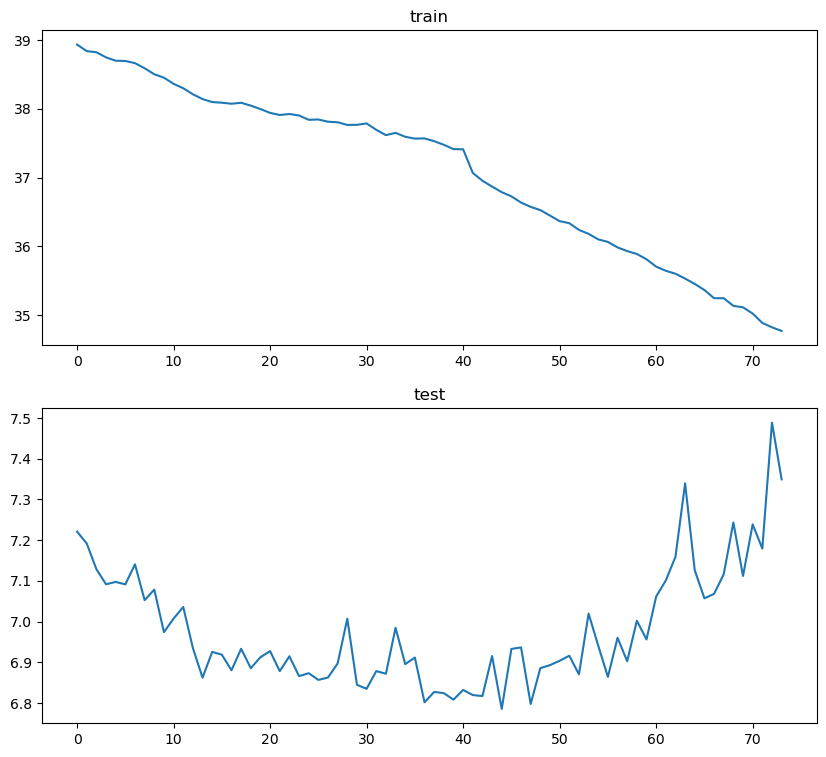

Epoch[74/175] | loss train:34.770967, test:7.349281


KeyboardInterrupt: 

In [111]:
# define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
best_loss = 10e9
# begin training
for epoch in range(epochs): 
    if epoch > 40:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        #torch.save(model_lstm.state_dict(), "./LSTMChildrenClassification")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [15]:
model_lstm.load_state_dict(torch.load("./LSTMChildrenClassification"))

<All keys matched successfully>

In [22]:
def GetAnswers(model, val_dataloader, is_trans=True):
    model.eval()
    answers = []
    for idx, (x, y) in enumerate(val_dataloader):
        if is_trans:
            x = x.transpose(1, 2)
        x = x.to('cuda')
        
        out = model(x)
        answers.append(out.detach().cpu().numpy().argmax(axis=1))
            
    return answers

In [22]:
preds = GetAnswers(model_lstm, test_dataloader)

In [28]:
preds = np.array(preds).reshape(len(preds)*batch_size)

In [33]:
len(preds)

46080

In [47]:
ind_st = siez_starts[test_idx] // 20 - 2
ind_pre = ind_st - preictal_time // 20

In [58]:
preictal_preds = preds[ind_pre + 2:ind_st]

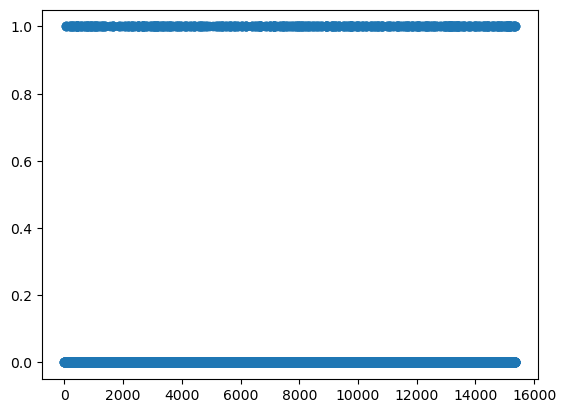

In [67]:
plt.scatter(range(len(preictal_preds)), preictal_preds)

In [73]:
print(preictal_preds.sum())
print(len(preictal_preds))
preictal_preds.sum() / len(preictal_preds)

666
15358


0.043365021487172806

In [79]:
preictal_preds[-1000:].sum()

62

In [80]:
preictal_preds[:1000].sum()

52

In [72]:
print(preds.sum())
print(len(preds))
preds.sum() / len(preds)

1130
46080


0.024522569444444444

In [71]:
len(preds)

46080

In [66]:
preictal_preds

1

In [61]:
preictal_time // 20

15360

In [63]:
for i in range(preictal_time // 20):
    if test_inout_seq[ind_pre +2 + i][1] == 0:
        print(i, "fuck")

15359 fuck


In [32]:
len(test_inout_seq)

46080

In [27]:
train_signals[0].shape

(23, 921600)

In [7]:
2996 * 256

766976

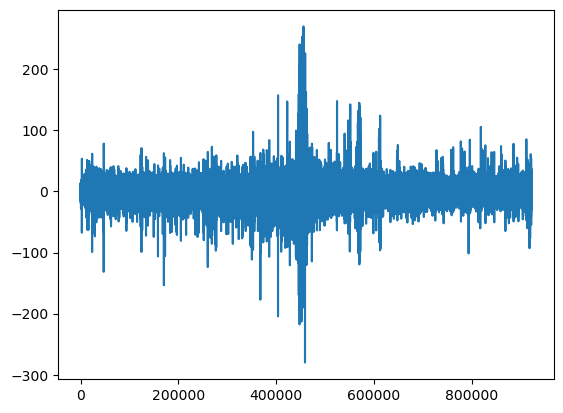

In [14]:
plt.plot(signals[4][0])

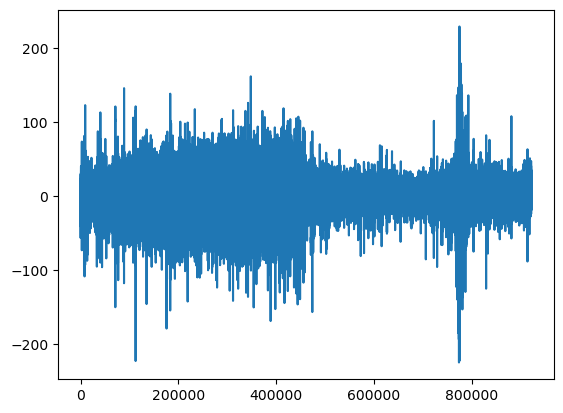

In [10]:
plt.plot(signals[0][0])

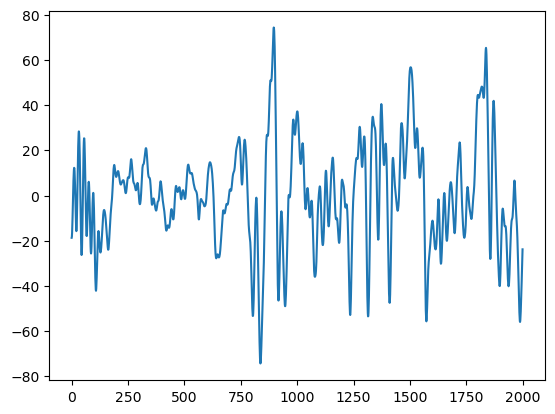

In [11]:
plt.plot(signals[0][0][2996 * 256 - 1000:2996 * 256 + 1000])

### WaveNet


In [9]:
train_window = 768

train_inout_seq = []
for i in train_idxs:
    pre_ind = ((siez_starts[i] - preictal_time) > 0) * (siez_starts[i] - preictal_time)
    train_inout_seq += create_inout_sequences(signals[i], train_window, pre_ind, siez_starts[i])

In [10]:
pre_ind = ((siez_starts[test_idx] - preictal_time) > 0) * (siez_starts[test_idx] - preictal_time)
test_inout_seq = create_inout_sequences(signals[test_idx], train_window, pre_ind, siez_starts[test_idx])

In [11]:
train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [12]:
#!L
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        x = super(CausalConv1d, self).forward(x)
        return x[:, :, :-self.padding[0]]

    



class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle (e.g. if set 10, max dilation = 2^(10-1))
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])
        
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        
        self.conv_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_channels,
            kernel_size=1)
        
        self.lin1 = nn.Linear(num_channels, 1)
        
        self.lin2 = nn.Linear((2 ** dilation_depth) * dilation_cycles, 100)
                
        self.relu = nn.ReLU()
        self.lin3 = nn.Linear(100, 2)
        

    def forward(self, x):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(x) # equal to x = torch.matmul(x.transpose(1, 2), model.conv_input.weight.squeeze().transpose(0, 1)) + model.conv_input.bias and transpose(1, 2)
        

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)


            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))
        
        x = x.transpose(1, 2)
        x = self.lin1(x)
        
        x = x[:, :, 0]
        
        x = self.relu(x)
        x = self.lin2(x)
        
        x = self.relu(x)
        x = self.lin3(x)
        
        
        
        return x

In [16]:
#!L
WaveNet_model = WaveNet(
    num_channels=23,
    residual_channels=32,
    gate_channels=32,
    skip_channels=64,
    pre_channels=128,
    dilation_cycles=3,
    dilation_depth=8,
    condition_channels=80,
    hop_size=300)
WaveNet_model.to("cuda")



WaveNet(
  (conv_input): Conv1d(23, 32, kernel_size=(1,), stride=(1,))
  (blocks_conv_filter): ModuleList(
    (0): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    (3): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
    (4): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(16,), dilation=(16,))
    (5): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(32,), dilation=(32,))
    (6): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(64,), dilation=(64,))
    (7): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(128,), dilation=(128,))
    (8): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (9): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (10): Cau

In [17]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        x = x.to('cuda')
        
        #x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')
        #y = y.view(-1)
        #print(y.size())

        out = model(x)

        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

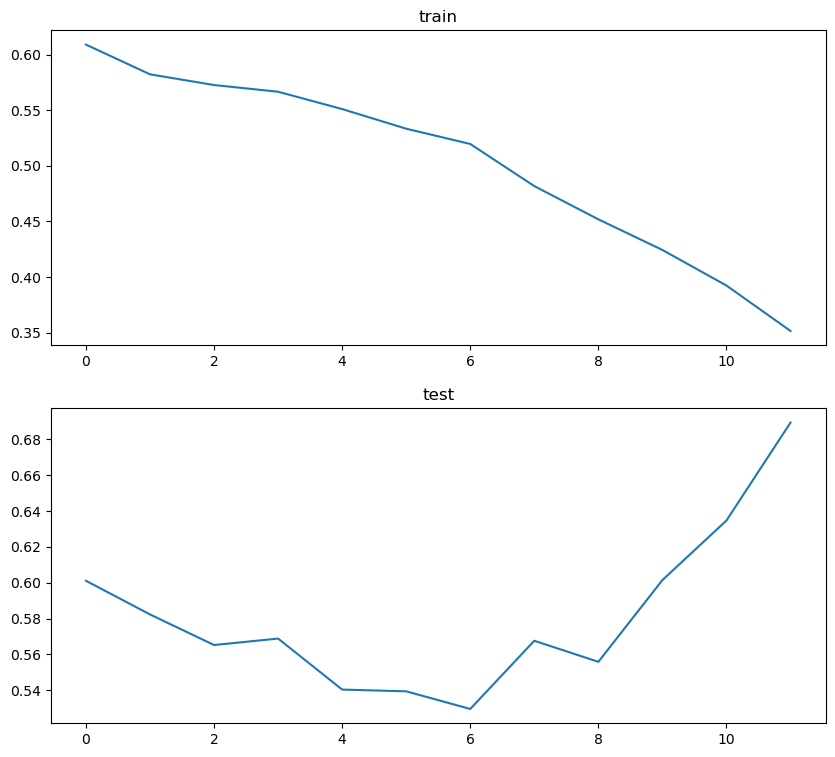

  1%|▉                                                                             | 12/1000 [02:14<3:04:23, 11.20s/it]

Epoch[12/1000] | loss train:0.351468, test:0.689427


  1%|▉                                                                             | 12/1000 [02:21<3:14:39, 11.82s/it]


KeyboardInterrupt: 

In [18]:
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(WaveNet_model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
lr = 0.001

losses_train = []
losses_test = []
best_loss = 10e9
# begin training
for epoch in tqdm(range(epochs)): 
    if epoch > 6:
        lr = 0.0005
    if epoch > 30:
        lr = 0.0001

    
    optimizer = optim.Adam(WaveNet_model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(WaveNet_model, train_dataloader, is_training=True)
    loss_val = run_epoch(WaveNet_model, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(WaveNet_model.state_dict(), "./WaveNetEEG")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [19]:
WaveNet_model.load_state_dict(torch.load("WaveNetEEG"))

<All keys matched successfully>

In [51]:
preds = GetAnswers(WaveNet_model, test_dataloader, is_trans=False)
preds = np.array(preds).reshape(len(preds)*batch_size)

In [52]:
ind_st = siez_starts[test_idx] // train_window 
ind_pre = ind_st - preictal_time // train_window

preictal_preds = np.array(preds[ind_pre:ind_st])

In [53]:
print(preictal_preds.sum())
print(len(preictal_preds))
preictal_preds.sum() / len(preictal_preds)

113
400


0.2825

In [54]:
print(preds.sum())
print(len(preds))
preds.sum() / len(preds)

169
1152


0.1467013888888889

In [57]:
test_win = [preds[ind_pre+i:ind_pre+i + 48].sum() for i in range(0, ind_st - ind_pre, 48)]

In [58]:
test_win

[11, 13, 11, 11, 12, 18, 15, 18, 4]